In [2]:
import numpy as np
import h5py
filename = "GW2_Andy.h5"
hdf = h5py.File(filename, 'r')
print(list(hdf.keys()))
background=hdf['background']
bbh=hdf['binaryblackhole']
ccsn=hdf['ccsn']
glitch=hdf['glitch']

['background', 'binaryblackhole', 'ccsn', 'glitch']


In [43]:
### normalize data using scipy standard scaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(background)
background = scaler.transform(background)
bbh = scaler.transform(bbh)
ccsn = scaler.transform(ccsn)
glitch = scaler.transform(glitch)

ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [3]:
print(background.shape)
print(bbh.shape)
print(ccsn.shape)
print(glitch.shape)

(2048, 2, 4096)
(2048, 2, 4096)
(2048, 2, 4096)
(2048, 2, 4096)


In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer
import scipy

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

In [26]:
background_labels = np.ones(background.shape[0])
bbh_labels = 2*np.ones(bbh.shape[0])
ccsn_labels= 3*np.ones(ccsn.shape[0])
glitch_labels = 3*np.ones(glitch.shape[0])

In [27]:
data = np.concatenate((background, bbh, ccsn, glitch), axis=0)
labels = np.concatenate((background_labels, bbh_labels, ccsn_labels, glitch_labels))

np.random.seed(42)

shuffler = np.random.permutation(range(data.shape[0]))
data = data[shuffler]
labels = labels[shuffler]

train_data=data[:5734,:,:]
train_data = np.transpose(train_data, (0, 2, 1))
print(train_data.shape)
train_labels=labels[:5734]
print(train_labels.shape)

validation_data=data[5734:5734+1638,:,:]
validation_data = np.transpose(validation_data, (0, 2, 1))
print(validation_data.shape)
validation_labels=labels[5734:5734+1638]
print(validation_labels.shape)

test_data=data[5734+1638:8192,:,:]
test_data = np.transpose(test_data, (0, 2, 1))
print(test_data.shape)
test_labels=labels[5734+1638:8192]
print(test_labels.shape)

(5734, 4096, 2)
(5734,)
(1638, 4096, 2)
(1638,)
(820, 4096, 2)
(820,)


In [28]:
encoder_inputseq_len = 10 
decoder_outputseq_len = 4
testing_sequence_len = 50
stride=1
num_features=2
n_samples=5734

train_data1=np.transpose(train_data, (1,0,2))
train_data1=train_data1[:,1,:]
L = train_data1.shape[0]  
num_samples = (L - encoder_inputseq_len - decoder_outputseq_len) // stride + 1


def generate_input_output_seqs(train_data, encoder_inputseq_len, decoder_outputseq_len, stride = 1, num_features = 2):
  
    train_data2=np.transpose(train_data, (1,0,2))
    train_data2=train_data2[:,1,:]
    L = train_data2.shape[0]  
        
    # use the formula to calculate how many samples we will take based on the encoder/decoder length and stride
    num_samples = (L - encoder_inputseq_len - decoder_outputseq_len) // stride + 1
    
    # empty arrays to contain the sequences
    train_input_seqs = np.zeros([num_samples, encoder_inputseq_len, num_features])
    train_output_seqs = np.zeros([num_samples, decoder_outputseq_len, num_features])    
    
    # fill up the array
    for ff in range(num_features):
        
        for ii in range(num_samples):
            
            start_x = stride * ii
            end_x = start_x + encoder_inputseq_len
            train_input_seqs[ii,:,ff] = train_data2[start_x:end_x,  ff]

            start_y = stride * ii + encoder_inputseq_len
            end_y = start_y + decoder_outputseq_len 
            train_output_seqs[ii,:,ff] = train_data2[start_y:end_y, ff]

    return train_input_seqs, train_output_seqs

train_input_seqs = np.zeros([n_samples, num_samples, encoder_inputseq_len, num_features])
train_output_seqs = np.zeros([n_samples, num_samples, decoder_outputseq_len, num_features])

for i in range(n_samples):
    train_input_seqs[i], train_output_seqs[i] = generate_input_output_seqs(train_data = train_data,
                                                                 encoder_inputseq_len = encoder_inputseq_len,
                                                                 decoder_outputseq_len = decoder_outputseq_len,
                                                                 stride = 1,
                                                                 num_features = 2)

KeyboardInterrupt: 

In [29]:
print(train_input_seqs.shape)
print(train_output_seqs.shape)

(5734, 4083, 10, 2)
(5734, 4083, 4, 2)


In [30]:
#### Define LSTM Model ####

class Encoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        
        super(Encoder, self).__init__()
        
        self.cnn = nn.Sequential((nn.Conv2d(in_channels=1, out_channels=20, 
                                  kernel_size=5, stride=1, padding=2)),
                                nn.ReLU(), 
                                nn.MaxPool2d(kernel_size=2),
                                nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2),
                                )
            
        
        #lstm model with batch size for the encoder
        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers, 
                                  batch_first = True)
        
    def forward(self, input_seq, hidden_state):
        
        cnn_output=self.cnn(input_seq)
        
        batch_size, channels, height, width = cnn_output.size()
        lstm_input = cnn_output.view(batch_size, -1, height * width)

        out, hidden = self.lstm(lstm_input, hidden_state)

        return out, hidden
        
        out, hidden = self.lstm(input_seq, hidden_state)
        
        return out, hidden     

class Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        
        super(Decoder, self).__init__()

        #lstm and fully connected network for the decoder so that we get a single output

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers,
                                  batch_first = True)
        
        self.fc_decoder = torch.nn.Linear(hidden_size, output_size)  

    def forward(self, input_seq, encoder_hidden_states):
        
        out, hidden = self.lstm(input_seq, encoder_hidden_states)
        out = self.fc_decoder(out)
        
        
        return out, hidden

    #combine the two into one model
class Encoder_Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, decoder_output_size, num_layers):

        super(Encoder_Decoder, self).__init__()

        self.Encoder = Encoder(input_size = input_size, hidden_size = hidden_size, 
                               num_layers = num_layers)
        
        self.Decoder = Decoder(input_size = input_size, hidden_size = hidden_size, 
                               output_size = decoder_output_size, num_layers = num_layers)

In [31]:
## Define Hyperparameters

torch.manual_seed(2)

input_size = 3  
hidden_size = 128
decoder_output_size = 10 
num_layers=2

model = Encoder_Decoder(input_size=input_size, hidden_size=hidden_size,
                        decoder_output_size=decoder_output_size, num_layers=num_layers)

learning_rate = 0.005    
epochs = 20

batchsize = 10
num_features = train_output_seqs.shape[3]

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

Encoder_Decoder(
  (Encoder): Encoder(
    (cnn): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (lstm): LSTM(3, 128, num_layers=2, batch_first=True)
  )
  (Decoder): Decoder(
    (lstm): LSTM(3, 128, num_layers=2, batch_first=True)
    (fc_decoder): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [32]:
train_loss_list = []

In [33]:
# Convert training data into torch tensors

train_input_seqs = torch.from_numpy(train_input_seqs).float()
train_output_seqs = torch.from_numpy(train_output_seqs).float()

# Split training data into mini-batches

train_batches_features = torch.split(train_input_seqs, batchsize)[:-1]
train_batches_targets = torch.split(train_output_seqs, batchsize)[:-1]

# Compute total number of mini-batches in training data

batch_split_num = len(train_batches_features)

KeyboardInterrupt: 

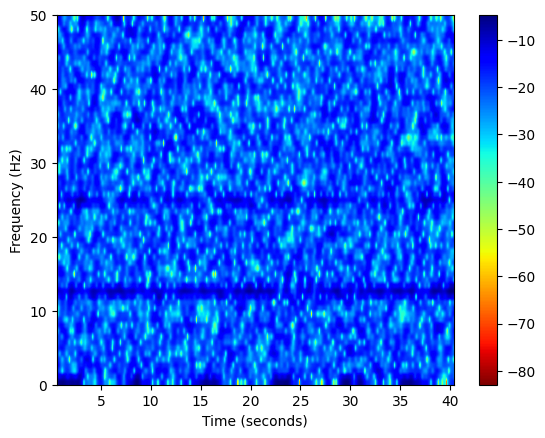

In [34]:
dt = 0.01               #Sampling interval of 0.01 seconds.

x = background[0][0]

plt.specgram(x, NFFT=128, Fs=1/dt, noverlap=120, cmap='jet_r', mode = 'magnitude')

plt.colorbar(); plt.xlabel("Time (seconds)"); plt.ylabel("Frequency (Hz)")
plt.show()

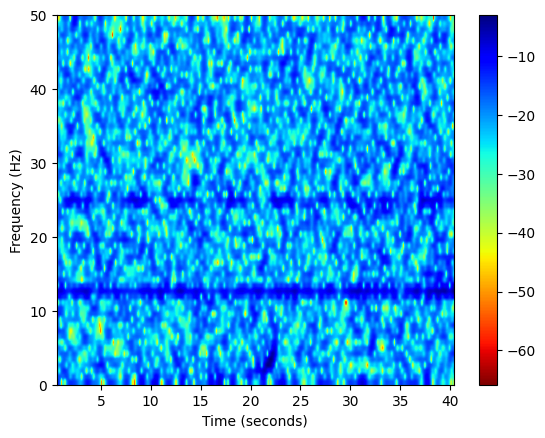

In [40]:
dt = 0.01            #Sampling interval of 0.01 seconds.

x = bbh[0][1]

plt.specgram(x, NFFT=128, Fs=1/dt, noverlap=120, cmap='jet_r', mode = 'magnitude')

plt.colorbar(); plt.xlabel("Time (seconds)"); plt.ylabel("Frequency (Hz)")
plt.show()

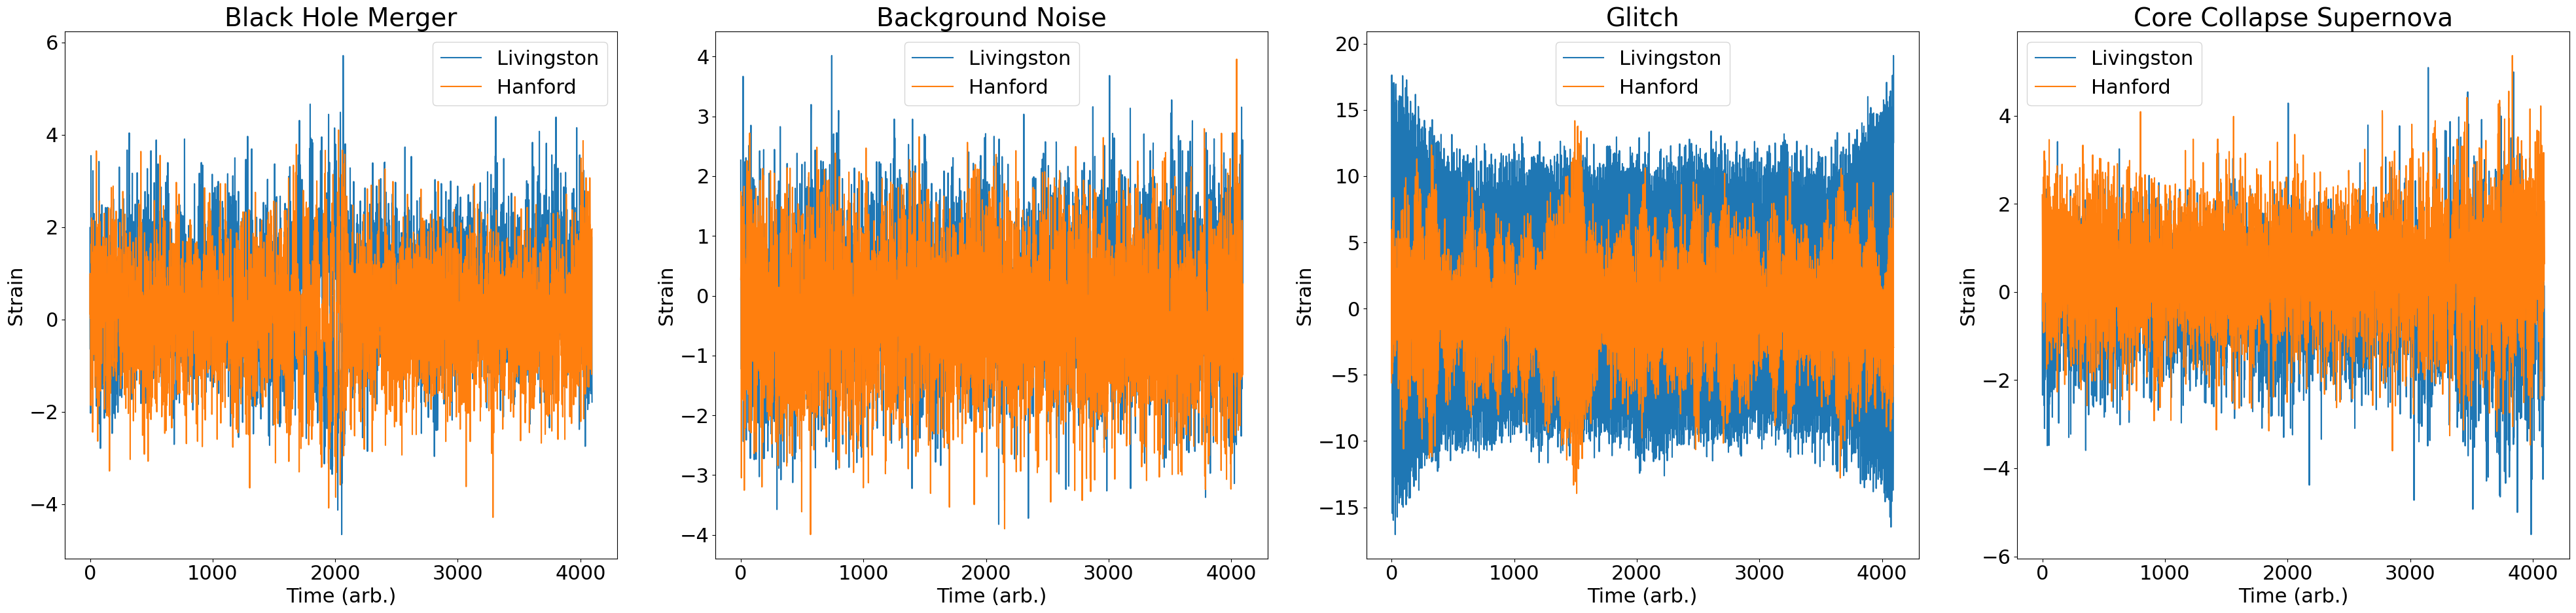

In [34]:
## 2 x 2 plot grid



SMALL_SIZE = 22
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, axs = plt.subplots(1, 4, figsize=(40, 10))


axs[0].plot(bbh[25][1], label = 'Livingston')
axs[0].plot(bbh[25][0], label = 'Hanford')
axs[0].set_title('Black Hole Merger')
axs[0].set_xlabel('Time (arb.)')
axs[0].set_ylabel('Strain')
axs[0].legend()

axs[1].plot(background[10][1], label = 'Livingston')
axs[1].plot(background[10][0], label = 'Hanford')
axs[1].set_title('Background Noise')
axs[1].set_xlabel('Time (arb.)')
axs[1].set_ylabel('Strain')
axs[1].legend()

axs[2].plot(glitch[50][1], label = 'Livingston')
axs[2].plot(glitch[50][0], label = 'Hanford')
axs[2].set_title('Glitch')
axs[2].set_xlabel('Time (arb.)')
axs[2].set_ylabel('Strain')
axs[2].legend()

axs[3].plot(ccsn[25][1], label = 'Livingston')
axs[3].plot(ccsn[25][0], label = 'Hanford')
axs[3].set_title('Core Collapse Supernova')
axs[3].set_xlabel('Time (arb.)')
axs[3].set_ylabel('Strain')
axs[3].legend()

plt.tight_layout()
plt.show()





In [134]:
### normalize data using scipy standard scaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
background_norm = scaler.fit_transform(background[:,0])
bbh_norm = scaler.transform(bbh[:,0])
glitch_norm = scaler.transform(glitch[:,0])
ccsn_norm = scaler.transform(ccsn[:,0])


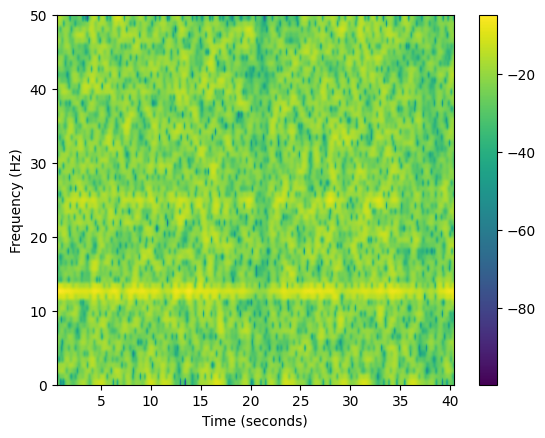

In [83]:


plt.specgram(background_norm[1], NFFT=128, Fs=1/dt, noverlap=120, mode = 'magnitude')

plt.colorbar(); plt.xlabel("Time (seconds)"); plt.ylabel("Frequency (Hz)")
plt.show()

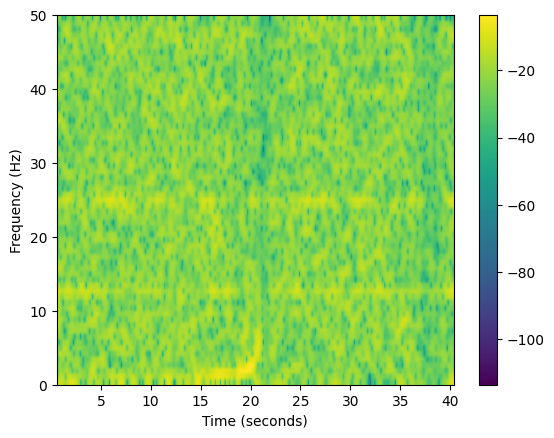

In [91]:
plt.specgram(bbh_norm[25], NFFT=128, Fs=1/dt, noverlap=120, mode = 'magnitude')

plt.colorbar(); plt.xlabel("Time (seconds)"); plt.ylabel("Frequency (Hz)")
plt.show()

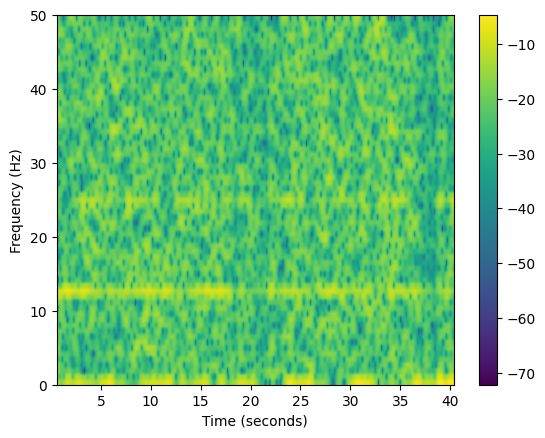

In [82]:
plt.specgram(glitch_norm[0], NFFT=128, Fs=1/dt, noverlap=120, mode = 'magnitude')

plt.colorbar(); plt.xlabel("Time (seconds)"); plt.ylabel("Frequency (Hz)")
plt.show()

In [80]:
background_norm.shape

(2048, 4096)

Text(0, 0.5, 'Frequency (Hz)')

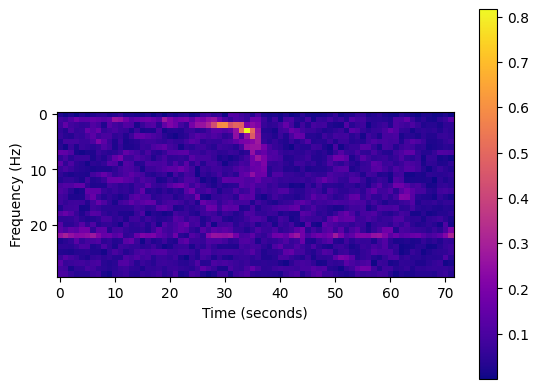

In [128]:
bbh_spec = scipy.signal.spectrogram(bbh_norm[25], fs = 1/dt, nperseg=175, noverlap=120, mode = 'magnitude')

## plot spectrogram
plt.axes().set_aspect(1)
plt.imshow(bbh_spec[2][0:30,:], aspect='equal', cmap='plasma')
plt.colorbar(); plt.xlabel("Time (seconds)"); plt.ylabel("Frequency (Hz)")

Text(0, 0.5, 'Frequency (Hz)')

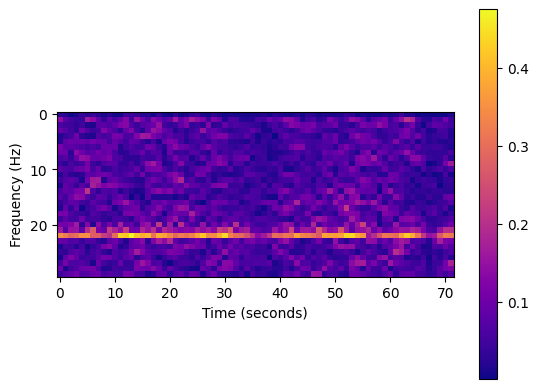

In [131]:
bkg_spec = scipy.signal.spectrogram(background_norm[25], fs = 1/dt, nperseg=175, noverlap=120, mode = 'magnitude')

## plot spectrogram
plt.axes().set_aspect(1)
plt.imshow(bkg_spec[2][0:30,:], aspect='equal', cmap='plasma')
plt.colorbar(); plt.xlabel("Time (seconds)"); plt.ylabel("Frequency (Hz)")

Text(0, 0.5, 'Frequency (Hz)')

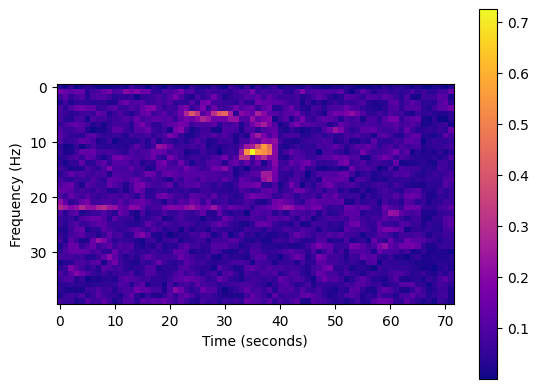

In [141]:
ccsn_spec = scipy.signal.spectrogram(ccsn_norm[2], fs = 1/dt, nperseg=175, noverlap=120, mode = 'magnitude')

## plot spectrogram
plt.axes().set_aspect(1)
plt.imshow(ccsn_spec[2][0:40,:], aspect='equal', cmap='plasma')
plt.colorbar(); plt.xlabel("Time (seconds)"); plt.ylabel("Frequency (Hz)")